Libraries

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\krish\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Part A — Data Preprocessing & Exploration 
1. Load the SMS spam dataset 
2. Convert label: "spam" → 1, "ham" → 0 
3. Text preprocessing: 
o Lowercase 
o Remove punctuation 
o Remove stopwords 
4. Convert text to numeric feature vectors using TF-IDF vectorizer 
5. Train–test split (80/20) 
6. Show class distribution

In [11]:
stop = set(stopwords.words('english'))

df = pd.read_csv("spam.csv", encoding="latin-1")[['v1','v2']]
df = df.rename(columns={'v1':'label','v2':'text'})

df['label'] = df['label'].map({'ham':0, 'spam':1})

def clean_text(t):
    t = str(t).lower()
    t = re.sub(r'[^a-z0-9\s]', ' ', t)
    words = [w for w in t.split() if w not in stop]
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text'])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Class distribution in full dataset:")
print(df['label'].value_counts(), "\n")

print("Train distribution:")
print(pd.Series(y_train).value_counts(), "\n")

print("Test distribution:")
print(pd.Series(y_test).value_counts())


Class distribution in full dataset:
label
0    4825
1     747
Name: count, dtype: int64 

Train distribution:
0    3859
1     598
Name: count, dtype: int64 

Test distribution:
0    966
1    149
Name: count, dtype: int64


Part B — Weak Learner Baseline 

Train a Decision Stump: 
DecisionTreeClassifier(max_depth=1) 

Report: 

• Train accuracy 
• Test accuracy 
• Confusion matrix 
• Comment on why stump performance is weak on text data 

In [12]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

train_pred = stump.predict(X_train)
test_pred = stump.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy :", accuracy_score(y_test, test_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred))

print("\nClassification Report:")
print(classification_report(y_test, test_pred, digits=4))


Train Accuracy: 0.8837783262284048
Test Accuracy : 0.895067264573991

Confusion Matrix (Test):
[[930  36]
 [ 81  68]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9199    0.9627    0.9408       966
           1     0.6538    0.4564    0.5375       149

    accuracy                         0.8951      1115
   macro avg     0.7869    0.7096    0.7392      1115
weighted avg     0.8843    0.8951    0.8869      1115



Part C — Manual AdaBoost (T = 15 rounds) 

Implement AdaBoost from scratch and after each iteration, print: 

• Iteration number 
• Misclassified sample indices 
• Weights of misclassified samples 
• Alpha value 

Then update and normalize weights. 

Also produce: 

• Plot: iteration vs weighted error 
• Plot: iteration vs alpha 

Finally report: 

• Train accuracy 
• Test accuracy 
• Confusion matrix 
• Short interpretation of weight evolution

In [13]:
T = 15
m = X_train.shape[0]

y_train_signed = np.where(y_train == 1, 1, -1)
y_test_signed  = np.where(y_test  == 1, 1, -1)

w = np.ones(m) / m

alphas = []
errors = []
stumps = []

train_scores = np.zeros(m)
test_scores = np.zeros(X_test.shape[0])

for t in range(1, T+1):

    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=w)
    stumps.append(stump)

    pred_train = stump.predict(X_train)
    pred_train_signed = np.where(pred_train == 1, 1, -1)

    misclassified = (pred_train != y_train)
    err_t = np.sum(w * misclassified) / np.sum(w)

    err_t = max(err_t, 1e-10)
    alpha_t = 0.5 * np.log((1 - err_t) / err_t)

    w = w * np.exp(-alpha_t * y_train_signed * pred_train_signed)
    w = w / np.sum(w)

    alphas.append(alpha_t)
    errors.append(err_t)

    print(f"\n=== Iteration {t} ===")
    print("Weighted error:", err_t)
    print("Alpha:", alpha_t)
    idx = np.where(misclassified)[0]
    print("Misclassified indices:", idx[:20])
    print("Weights of those samples:", w[idx[:20]])

    train_scores += alpha_t * pred_train_signed

    pred_test = stump.predict(X_test)
    pred_test_signed = np.where(pred_test == 1, 1, -1)
    test_scores += alpha_t * pred_test_signed


final_train_pred = np.where(train_scores > 0, 1, 0)
final_test_pred  = np.where(test_scores > 0, 1, 0)

print("\n\n===== FINAL RESULTS =====")
print("Train Accuracy:", accuracy_score(y_train, final_train_pred))
print("Test Accuracy :", accuracy_score(y_test, final_test_pred))
print("\nConfusion Matrix (test):")
print(confusion_matrix(y_test, final_test_pred))



=== Iteration 1 ===
Weighted error: 0.11622167377159526
Alpha: 1.0143534603557114
Misclassified indices: [ 14  42  49  50  59  62  86  93  96 100 103 115 121 140 142 157 162 194
 195 196]
Weights of those samples: [0.00096525 0.00096525 0.00096525 0.00096525 0.00096525 0.00096525
 0.00096525 0.00096525 0.00096525 0.00096525 0.00096525 0.00096525
 0.00096525 0.00096525 0.00096525 0.00096525 0.00096525 0.00096525
 0.00096525 0.00096525]

=== Iteration 2 ===
Weighted error: 0.24812732981049812
Alpha: 0.5543124734974825
Misclassified indices: [  9  15  22  31  39  49  59  66  76  88  93 114 121 123 159 162 166 174
 194 203]
Weights of those samples: [0.00025579 0.00025579 0.00025579 0.00025579 0.00025579 0.00194507
 0.00194507 0.00025579 0.00025579 0.00025579 0.00194507 0.00025579
 0.00194507 0.00025579 0.00025579 0.00194507 0.00025579 0.00025579
 0.00194507 0.00194507]

=== Iteration 3 ===
Weighted error: 0.3449648339029436
Alpha: 0.3206232208859478
Misclassified indices: [ 0  1  2  3  4

Part D — Sklearn AdaBoost 

Train: 

AdaBoostClassifier( 

    base_estimator=DecisionTreeClassifier(max_depth=1), 

    n_estimators=100, 

    learning_rate=0.6 
    
) 

Report: 

• Train accuracy 
• Test accuracy 
• Confusion matrix 
• Compare performance with manual implementation 

In [14]:

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6,
    random_state=42
)

ada.fit(X_train, y_train)

y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

print("Sklearn AdaBoost Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Sklearn AdaBoost Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))


Sklearn AdaBoost Train Accuracy: 0.9181063495624859
Sklearn AdaBoost Test Accuracy : 0.9219730941704036

Confusion Matrix (Test):
[[966   0]
 [ 87  62]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9174    1.0000    0.9569       966
           1     1.0000    0.4161    0.5877       149

    accuracy                         0.9220      1115
   macro avg     0.9587    0.7081    0.7723      1115
weighted avg     0.9284    0.9220    0.9076      1115



Q2. Dataset Description 
You  will  use  the  UCI  Heart  Disease  dataset  (available  in  sklearn.datasets). 
This dataset contains patient medical features used to predict heart disease

Part A — Baseline Model (Weak Learner) 

1. Load the dataset and preprocess (handle categorical features, scaling if needed) 

2. Train one Decision Stump (max_depth = 1) 

3. Report: 

• Training & test accuracy 

• Confusion matrix 

• Classification report 

4. What shortcomings do you observe in a single stump?

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.datasets import fetch_openml

heart = fetch_openml(name="heart-disease", version=1, as_frame=True)
df = heart.frame

df['target'] = df['target'].astype(int)

X = df.drop(columns=['target'])
y = df['target']

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred  = stump.predict(X_test)

print("=== Decision Stump Performance ===\n")

print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, digits=4))

=== Decision Stump Performance ===

Train Accuracy: 0.78099173553719
Test Accuracy : 0.7049180327868853

Confusion Matrix:
[[17 11]
 [ 7 26]]

Classification Report:
              precision    recall  f1-score   support

           0     0.7083    0.6071    0.6538        28
           1     0.7027    0.7879    0.7429        33

    accuracy                         0.7049        61
   macro avg     0.7055    0.6975    0.6984        61
weighted avg     0.7053    0.7049    0.7020        61



Part B — Train AdaBoost 
1. Train AdaBoostClassifier using decision stumps as base learners 
2. Use: 
• n_estimators = [5, 10, 25, 50, 100] 
• learning_rate = [0.1, 0.5, 1.0] 
3. For each combination: 
• Train model 
• Compute accuracy on test set 
4. Plot: 
• n_estimators vs accuracy for each learning_rate 
5. Identify best config (highest accuracy)

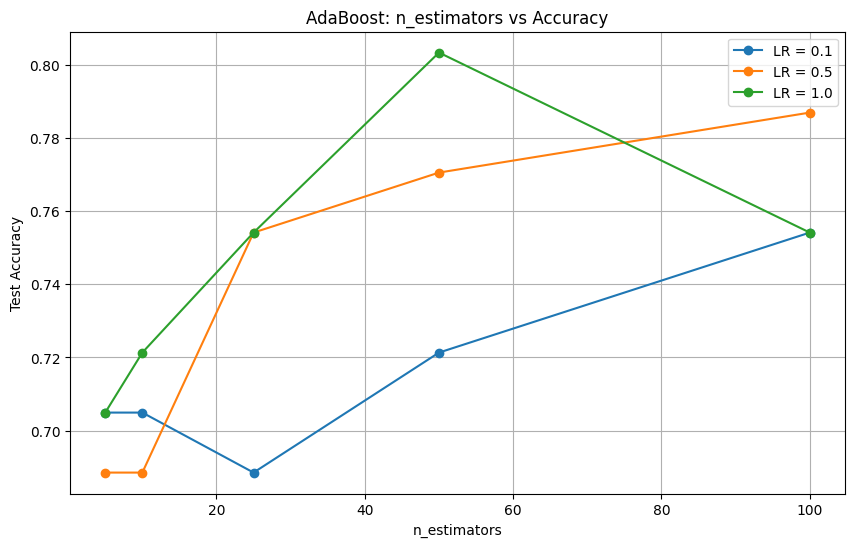

Best Configuration:
n_estimators: 50
learning_rate: 1.0
Best Test Accuracy: 0.8032786885245902


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = {}

for lr in learning_rates:
    acc_list = []
    for n in n_estimators_list:
        model = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n,
            learning_rate=lr,
            random_state=42
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        acc_list.append(acc)
    results[lr] = acc_list

plt.figure(figsize=(10,6))
for lr in learning_rates:
    plt.plot(n_estimators_list, results[lr], marker='o', label=f"LR = {lr}")

plt.xlabel("n_estimators")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost: n_estimators vs Accuracy")
plt.legend()
plt.grid(True)
plt.show()

best_acc = -1
best_cfg = None

for lr in learning_rates:
    for i, n in enumerate(n_estimators_list):
        acc = results[lr][i]
        if acc > best_acc:
            best_acc = acc
            best_cfg = (n, lr)

print("Best Configuration:")
print("n_estimators:", best_cfg[0])
print("learning_rate:", best_cfg[1])
print("Best Test Accuracy:", best_acc)


Part C — Misclassification Pattern 
1. For the best model, collect the sample weights and prediction errors at each iteration. 
2. Plot: 
• Weak learner error vs iteration 
• Sample weight distribution after final boosting stage 
3. Explain: 
• Which samples got highest weights? 
• Why does AdaBoost focus on them?

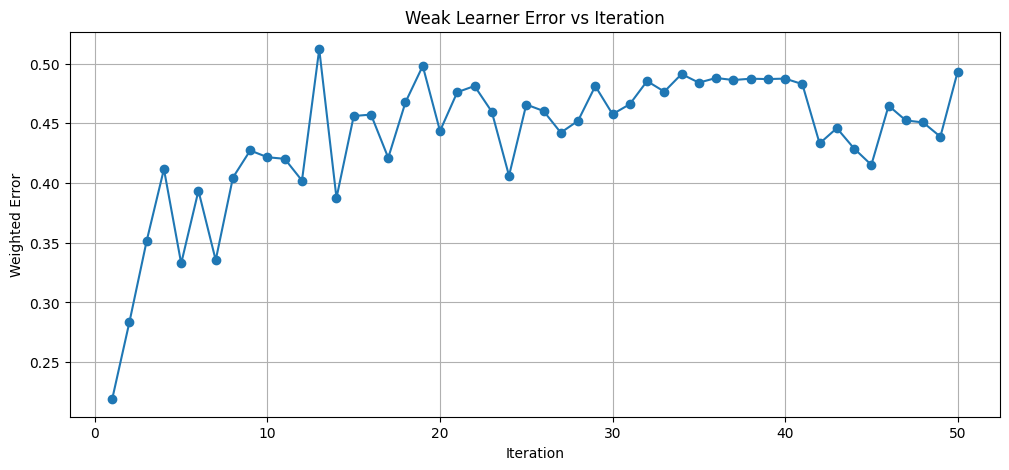

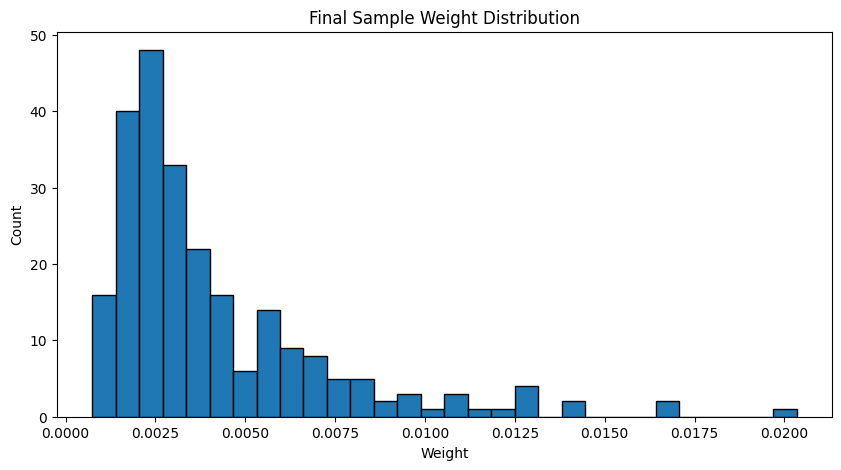

Top 10 highest weight samples (indices):
[214   5  49  65 181 224 113  25  26  10]

Corresponding labels:
[0 1 0 0 0 1 1 0 1 0]

Corresponding weights:
[0.01240153 0.01256171 0.012916   0.01294491 0.01301425 0.01397144
 0.01437142 0.01655149 0.0170461  0.02034093]


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

best_n, best_lr = best_cfg  # from Part B

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)

ada.fit(X_train, y_train)

staged_errors = []
staged_weights = []

sample_weights = np.ones(len(X_train)) / len(X_train)

for estimator in ada.estimators_:
    pred = estimator.predict(X_train)
    incorrect = (pred != y_train)

    error_t = np.sum(sample_weights * incorrect)
    staged_errors.append(error_t)

    alpha_t = ada.learning_rate * 0.5 * np.log((1 - error_t) / error_t)
    sample_weights = sample_weights * np.exp(alpha_t * incorrect)
    sample_weights = sample_weights / sample_weights.sum()

    staged_weights.append(sample_weights.copy())

final_weights = staged_weights[-1]

plt.figure(figsize=(12,5))
plt.plot(range(1, len(staged_errors)+1), staged_errors, marker='o')
plt.title("Weak Learner Error vs Iteration")
plt.xlabel("Iteration")
plt.ylabel("Weighted Error")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.hist(final_weights, bins=30, edgecolor='black')
plt.title("Final Sample Weight Distribution")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.show()

final_weights = np.array(final_weights)

print("Top 10 highest weight samples (indices):")
top_indices = np.argsort(final_weights)[-10:]
print(top_indices)

print("\nCorresponding labels:")
print(y_train.iloc[top_indices].values)

print("\nCorresponding weights:")
print(final_weights[top_indices])


Part D — Visual Explainability 
1. Plot feature importance from AdaBoost. 
2. Identify top 5 most important features. 
3. Explain why these features may matter medically.

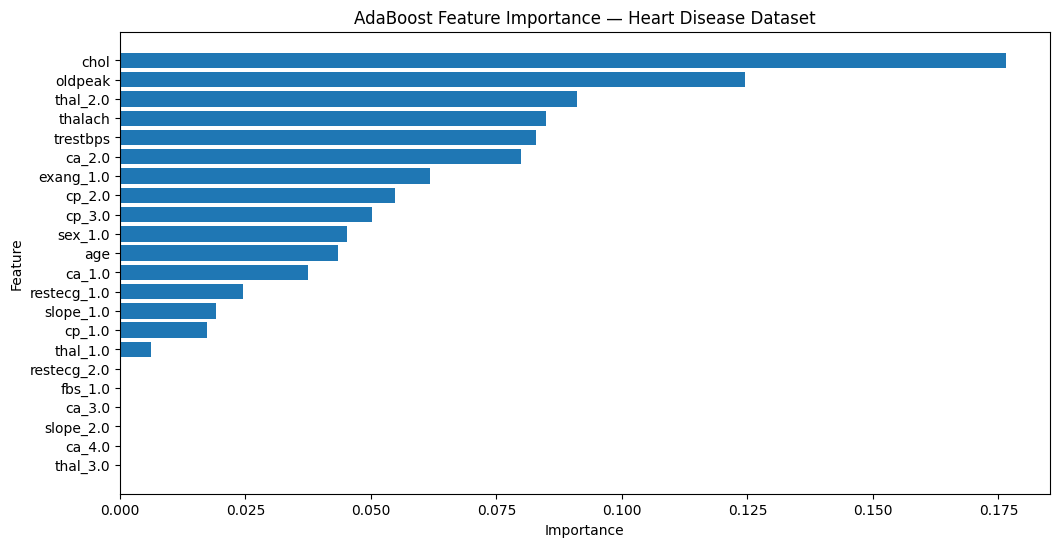

Top 5 Most Important Features:
     feature  importance
2       chol    0.176430
4    oldpeak    0.124576
20  thal_2.0    0.091102
3    thalach    0.084855
1   trestbps    0.082881


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada_best = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=best_n,
    learning_rate=best_lr,
    random_state=42
)

ada_best.fit(X_train, y_train)

importances = ada_best.feature_importances_

feat_imp = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
plt.barh(feat_imp['feature'], feat_imp['importance'])
plt.gca().invert_yaxis()
plt.title("AdaBoost Feature Importance — Heart Disease Dataset")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

top5 = feat_imp.head(5)
print("Top 5 Most Important Features:")
print(top5)


WISDM Smartphone & Watch Motion Sensor Dataset 
(Available on UCI / Kaggle → WISDM_ar_v1.1_raw.txt)

Part A — Data Preparation 
1. Load the dataset (WISDM_ar_v1.1_raw.txt) 
2. Extract only numeric accelerometer X, Y, Z columns 
3. Create activity label as binary: 
Activity Type Label 
Jogging, Up 1 
Walk, Sit, Stand, Down 0 
4. Handle missing/dirty entries 
5. Train-test split (70/30)

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split

filepath = "WISDM_ar_v1.1_raw.txt"

activities = []
xs = []
ys = []
zs = []

with open(filepath, "r") as f:
    for line in f:
        match_act = re.search(r',(.*?)\s*,', line)
        if not match_act:
            continue
        act = match_act.group(1).strip()

        match_xyz = re.findall(r'(-?\d+\.\d+)', line)

        if len(match_xyz) != 3:
            continue
        
        try:
            x, y, z = map(float, match_xyz)
        except:
            continue

        activities.append(act)
        xs.append(x)
        ys.append(y)
        zs.append(z)

df = pd.DataFrame({
    "activity": activities,
    "x": xs,
    "y": ys,
    "z": zs
})

print("Loaded rows:", len(df))

vigorous = ["Jogging", "Upstairs"]
df["label"] = df["activity"].apply(lambda a: 1 if a in vigorous else 0)

df = df.dropna()

print(df["label"].value_counts())

X = df[["x","y","z"]].values
y = df["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Loaded rows: 1066460
label
0    621038
1    445422
Name: count, dtype: int64
Train: (746522, 3) Test: (319938, 3)


Part B — Weak Classifier Baseline 
Train a Decision Stump: 
DecisionTreeClassifier(max_depth=1) 
Report: 
• Accuracy (train + test) 
• Confusion matrix 
• Interpretation of stump result

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred  = stump.predict(X_test)

print("\nTrain Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy :", accuracy_score(y_test, y_test_pred))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred))

print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred, digits=4))



Train Accuracy: 0.6486305828897206
Test Accuracy : 0.6492976764248073

Confusion Matrix (Test):
[[169280  17031]
 [ 95172  38455]]

Classification Report (Test):
              precision    recall  f1-score   support

           0     0.6401    0.9086    0.7511    186311
           1     0.6931    0.2878    0.4067    133627

    accuracy                         0.6493    319938
   macro avg     0.6666    0.5982    0.5789    319938
weighted avg     0.6622    0.6493    0.6072    319938



Part C — Manual AdaBoost (T = 20 rounds) 
Write your own AdaBoost with full weight tracking. 
At each iteration, print: 
• Iteration number 
• Misclassified sample indices 
• Weights of misclassified samples 
Note: Normalize weights after update. 
Also plot: 
• Boosting round vs error 
• Boosting round vs alpha 
Finally report: 
• Train accuracy 
• Test accuracy 
• Confusion matrix 
• Interpretation: how weights shifted over time


=== Iteration 1 ===
Weighted Error: 0.3513694171102794
Alpha Value: 0.3065126022564021
Misclassified sample indices (first 20): [ 0  4  5 17 19 23 26 29 31 33 36 39 42 43 44 46 49 50 51 54]
Weights of those samples (first 20): [1.90617792e-06 1.90617792e-06 1.90617792e-06 1.90617792e-06
 1.90617792e-06 1.90617792e-06 1.90617792e-06 1.90617792e-06
 1.90617792e-06 1.90617792e-06 1.90617792e-06 1.90617792e-06
 1.90617792e-06 1.90617792e-06 1.90617792e-06 1.90617792e-06
 1.90617792e-06 1.90617792e-06 1.90617792e-06 1.90617792e-06]

=== Iteration 2 ===
Weighted Error: 0.4602021503259647
Alpha Value: 0.0797644334175035
Misclassified sample indices (first 20): [ 0  3  4 17 19 20 23 26 27 29 31 32 33 36 39 42 43 44 46 50]
Weights of those samples (first 20): [2.07102240e-06 1.12189273e-06 2.07102240e-06 2.07102240e-06
 2.07102240e-06 1.12189273e-06 2.07102240e-06 2.07102240e-06
 1.12189273e-06 2.07102240e-06 2.07102240e-06 1.12189273e-06
 2.07102240e-06 2.07102240e-06 2.07102240e-06 2.0710224

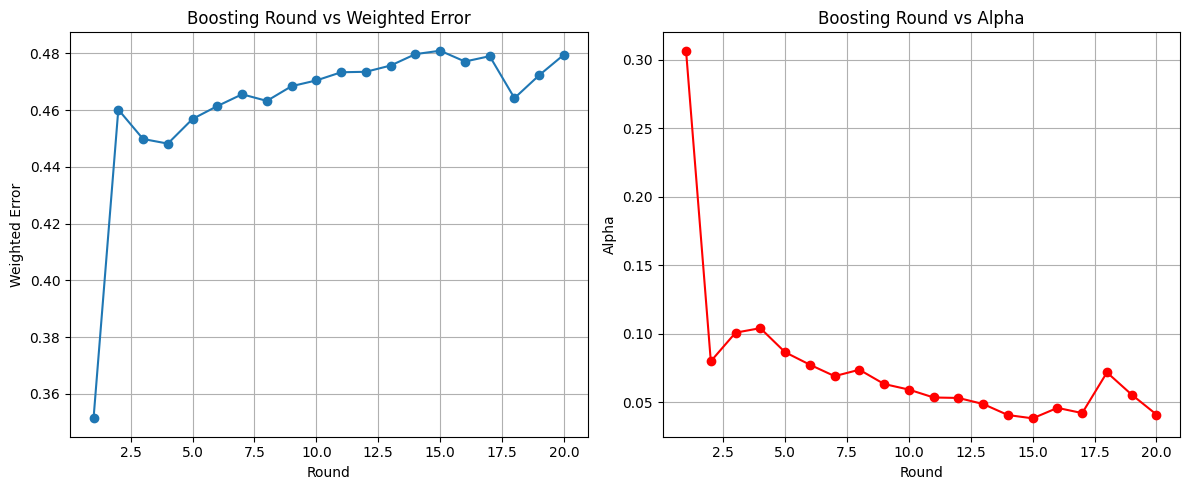

In [14]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

T = 20
m = len(X_train)

y_train_signed = np.where(y_train == 1, 1, -1)
y_test_signed  = np.where(y_test  == 1, 1, -1)

w = np.ones(m) / m

alphas = []
errors = []
stumps = []

train_scores = np.zeros(m)
test_scores  = np.zeros(len(X_test))

for t in range(1, T+1):

    stump = DecisionTreeClassifier(max_depth=1, random_state=42)
    stump.fit(X_train, y_train, sample_weight=w)
    stumps.append(stump)

    pred_train = stump.predict(X_train)
    pred_train_signed = np.where(pred_train == 1, 1, -1)

    misclassified = (pred_train != y_train)
    error_t = np.sum(w * misclassified)

    error_t = max(error_t, 1e-10)

    alpha_t = 0.5 * np.log((1 - error_t) / error_t)

    w = w * np.exp(-alpha_t * y_train_signed * pred_train_signed)

    w = w / np.sum(w)

    alphas.append(alpha_t)
    errors.append(error_t)

    print(f"\n=== Iteration {t} ===")
    print("Weighted Error:", error_t)
    print("Alpha Value:", alpha_t)

    idx = np.where(misclassified)[0]
    print("Misclassified sample indices (first 20):", idx[:20])
    print("Weights of those samples (first 20):", w[idx[:20]])

    train_scores += alpha_t * pred_train_signed

    pred_test_t = stump.predict(X_test)
    pred_test_signed = np.where(pred_test_t == 1, 1, -1)
    test_scores += alpha_t * pred_test_signed


final_train_pred = np.where(train_scores > 0, 1, 0)
final_test_pred  = np.where(test_scores > 0, 1, 0)

print("\n===== FINAL MANUAL ADABOOST RESULTS =====")
print("Train Accuracy:", accuracy_score(y_train, final_train_pred))
print("Test Accuracy :", accuracy_score(y_test, final_test_pred))
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, final_test_pred))


plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, T+1), errors, marker='o')
plt.title("Boosting Round vs Weighted Error")
plt.xlabel("Round")
plt.ylabel("Weighted Error")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(range(1, T+1), alphas, marker='o', color='red')
plt.title("Boosting Round vs Alpha")
plt.xlabel("Round")
plt.ylabel("Alpha")
plt.grid(True)

plt.tight_layout()
plt.show()

Part D — Sklearn AdaBoost 
Train: 
AdaBoostClassifier( 
    base_estimator = DecisionTreeClassifier(max_depth=1), 
    n_estimators = 100, 
    learning_rate = 1.0 
) 
Report: 
• Train/Test accuracy 
• Confusion matrix 
• Compare with your manual implementation

In [15]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)

ada.fit(X_train, y_train)

train_pred = ada.predict(X_train)
test_pred = ada.predict(X_test)

print("Train Accuracy:", accuracy_score(y_train, train_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))

print("\nComparison with Manual AdaBoost:")
print("Manual Train Accuracy:", accuracy_score(y_train, final_train_pred))
print("Manual Test Accuracy :", accuracy_score(y_test, final_test_pred))

Train Accuracy: 0.6947042418039924
Test Accuracy: 0.6955628903099975
Confusion Matrix:
 [[162297  24014]
 [ 73387  60240]]

Comparison with Manual AdaBoost:
Manual Train Accuracy: 0.692934702527186
Manual Test Accuracy : 0.6936281404522127
